In [56]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from src.classifier import Classifier
import matplotlib as mpl 
from src.tools import MMSeqs 
from utils import *
from src.graph import NeighborsGraph 
from scipy.stats import pearsonr

%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
annotated_results_df = pd.read_csv('../data/results/dataset_false_negative_annotated.csv', index_col=0)
annotated_results_df['nested'] = annotated_results_df.category.str.contains('nested')

spurious_ids = annotated_results_df[annotated_results_df.category.str.contains('error') | (annotated_results_df.category == 'fragment')].index.values
real_ids = annotated_results_df[~annotated_results_df.category.str.contains('error') & (annotated_results_df.category != 'fragment')].index.values
print('Num. mislabeled real sequences:', len(spurious_ids))
print('Num. misclassified real sequences:', len(real_ids))

if os.path.exists('results-1-3.csv'):
    model_name = 'model_v2'
    model = Classifier.load('../models/model_v2.pkl')

    train_results_df = pd.read_csv('../data/results/dataset_train_predict.csv', index_col=0).assign(dataset='train')
    test_results_df = pd.read_csv('../data/results/dataset_test_predict.csv', index_col=0).assign(dataset='test')

    results_df = pd.concat([train_results_df, test_results_df])
    results_df = results_df.merge(pd.read_csv('../data/dataset/dataset.csv', index_col=0), left_index=True, right_index=True)
    results_df = apply_thresholds(results_df)
    results_df['length'] = results_df.seq.apply(len)
    results_df['nested'] = results_df.index.isin(annotated_results_df[annotated_results_df.nested].index)
    results_df.loc[spurious_ids, 'label'] = 0 # Correct the labels of the mislabeled SwissProt sequences.

    graph = NeighborsGraph.load('../data/dataset/dataset_graph.pkl')
    results_df = get_neighbor_info(results_df, graph)
    results_df.to_csv('results-1-3.csv')

else:
    results_df = pd.read_csv('results-1-3.csv', index_col=0)

print('Num. misclassified smORFs:', (results_df.loc[real_ids].length < 100).sum(), f'({get_percent((results_df.loc[real_ids].length < 100).sum(), len(spurious_ids))})')
print('Num. misclassified nested smORFs:', ((results_df.loc[real_ids].length < 100) & (results_df.nested)).sum())



Num. mislabeled real sequences: 128
Num. misclassified real sequences: 172


get_neighbor_info: 100%|██████████| 276586/276586 [03:22<00:00, 1367.62it/s]


Num. misclassified smORFs: 125 (97.66%)
Num. misclassified nested smORFs: 4


In [76]:
# is_misclassified = lambda df : (df.label.map({0:'spurious', 1:'real'}) != df.model_label) & (df.model_label != 'uncertain')
is_false_negative = lambda df : (df.label.isin([1, 'real'])) & (df.model_label == 'spurious')

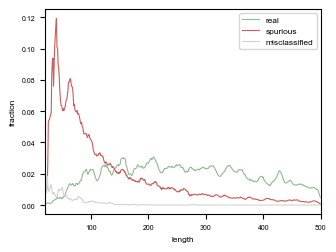

In [149]:
# Can't just correlate sequence length and model output, as the spurious-labeled sequences have a distribution that 
# has a peak around __ amino acids; length bias would show that sequences closest in length to this peak are more likely to be 
# classified as spurious. 

def figure_1(results_df:pd.DataFrame, path:str='../figures/results-1.3_figure-1.pdf', normalize:str='bin', max_length:int=100):

    fig, ax = get_figure() 

    figure_df = results_df[results_df.length < max_length].copy()
    figure_df['label'] = figure_df.label.map({1:'real', 0:'spurious'})
    figure_df['misclassified'] = (figure_df.model_label != figure_df.label) & (figure_df.model_label != 'uncertain')

    delta = 5

    ax_df = pd.DataFrame(index=pd.Series(np.arange(15, max_length), name='length'))
    palette = {'real':'darkseagreen', 'spurious':'indianred'}

    for label, df in figure_df.groupby('label'):
        counts = np.array([((df.length < (length + delta)) & (df.length > (length - delta))).sum(axis=None) for length in ax_df.index])

        if (normalize == 'bin'):
            bin_totals = np.array([((figure_df.length < (length + delta)) & (figure_df.length > (length - delta))).sum() for length in ax_df.index])
            ax_df[f'fraction'] = counts / bin_totals
        elif (normalize == 'total'):
            total = (figure_df.label == label).sum()
            ax_df['fraction'] = counts / total 

        sns.lineplot(data=ax_df, x='length', y='fraction', color=palette[label], ax=ax, label=label)

    counts = np.array([((figure_df.length < (length + delta)) & (figure_df.length > (length - delta)) & figure_df.misclassified).sum(axis=None) for length in ax_df.index])
    totals = np.array([((figure_df.length < (length + delta)) & (figure_df.length > (length - delta))).sum(axis=None) for length in ax_df.index])
    ax_df[f'fraction'] = counts / totals
    sns.lineplot(data=ax_df, x='length', y='fraction', ax=ax, color='lightgray', label='misclassified')

    # ax_df[f'fraction'] = counts / figure_df.misclassified.sum()
    # sns.lineplot(data=ax_df, x='length', y='fraction', ax=ax, color='gray')

    ax.legend()
    
    ax.set_xlim(xmin=20, xmax=max_length)
    # ax.axvline(35, ls='--', lw=0.7, color='black')
    # ax.axvline(25, ls='--', lw=0.7, color='black')
    # ax.axvline(65, ls='--', lw=0.7, color='black')

    save_figure(fig, path)

figure_1(results_df, normalize='total', max_length=500)

# Based on this figure, the worry is that short sequences tend to condense in embedding space due to a length effect, which 
# would result in the misclassification of short, real sequences. 

# If this were the case, we would expect that the nearest neighbors of short sequences would be very similar in length. 


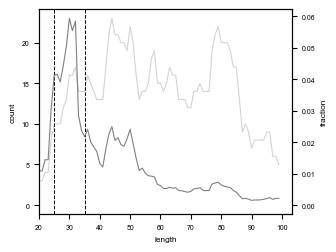

In [ ]:
def figure(results_df:pd.DataFrame, path:str=None):

    fig, ax = get_figure() 

    figure_df = results_df[results_df.length < 100].copy()
    figure_df['label'] = figure_df.label.map({1:'real', 0:'spurious'})
    figure_df['false_negative'] = is_false_negative(figure_df)

    delta = 5

    ax_df = pd.DataFrame(index=pd.Series(np.arange(15, 100), name='length'))
    palette = {'real':'darkseagreen', 'spurious':'indianred'}

    counts = np.array([((figure_df.length < (length + delta)) & (figure_df.length > (length - delta)) & figure_df.false_negative).sum(axis=None) for length in ax_df.index])
    totals = np.array([((figure_df.length < (length + delta)) & (figure_df.length > (length - delta)) & (figure_df.label == 'real')).sum(axis=None) for length in ax_df.index])
    # totals = np.array([((figure_df.length < (length + delta)) & (figure_df.length > (length - delta))).sum(axis=None) for length in ax_df.index])
    ax_df['fraction'] = counts / totals
    ax_df['count'] = counts
    sns.lineplot(data=ax_df, x='length', y='count', ax=ax, color='lightgray')
    sns.lineplot(data=ax_df, x='length', y='fraction', ax=ax.twinx(), color='gray')
    
    # ax.set_xlim(xmin=15, xmax=100)
    ax.axvline(25, ls='--', lw=0.7, color='black')
    ax.axvline(35, ls='--', lw=0.7, color='black')
    ax.set_xlim(xmin=20)

    save_figure(fig, path)

figure(results_df)

In [78]:
results_df[is_false_negative(results_df)].nearest_neighbor_same_label.value_counts() #.value_counts()
# results_df[results_df['product'].str.contains('Putative membrane protein insertion efficiency factor')].sort_values('model_output_1')[['nearest_neighbor_id', 'nearest_neighbor_product']]
results_df[(results_df.length < 100) & results_df.real].nearest_neighbor_same_label.value_counts()


nearest_neighbor_same_label
True     19111
False       79
Name: count, dtype: int64

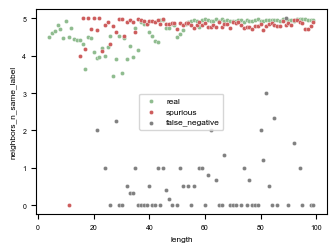

In [155]:
# sns.scatterplot(neighbor_length_df[neighbor_length_df.model_label == 'spurious'], x='length', y='neighbor_length_mean')
def figure(results_df:pd.DataFrame):
    fig, ax = get_figure()
    x_min, x_max = 0, 100
    palette = {'real':'darkseagreen', 'spurious':'indianred', 'false_negative':'gray'}

    figure_df = results_df[results_df.length.isin(np.arange(x_min, x_max))].copy()
    figure_df['label'] = figure_df.label.map({1:'real', 0:'spurious'})
    figure_df['false_negative'] = is_false_negative(figure_df)

    masks = {'real':(figure_df.label == 'real') & ~figure_df.false_negative, 'spurious':(figure_df.label == 'spurious'), 'false_negative':figure_df.false_negative}
    for label in ['real', 'spurious', 'false_negative']:
        mask = masks[label]
        # sns.scatterplot(x=figure_df[mask].length, y=figure_df[mask].neighbor_n_same_label, label=label, color=palette[label]) #, hue='model_label', palette=palette)
        sns.scatterplot(x=figure_df[mask].groupby('length').length.first(), y=figure_df[mask].groupby('length').neighbors_n_same_label.mean(), label=label, color=palette[label]) #, hue='model_label', palette=palette)

    save_figure(fig)

figure(results_df)

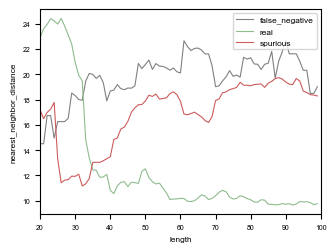

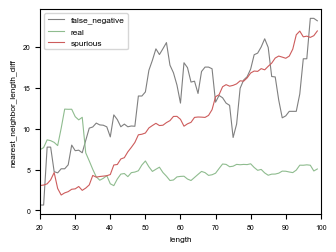

In [144]:

def figure(results_df:pd.DataFrame, y='nearest_neighbor_distance', max_length:int=100):

    min_length = 20
    fig, ax = get_figure() 

    figure_df = results_df[(results_df.length < max_length) & (results_df.length > min_length)].copy()
    figure_df['label'] = figure_df.label.map({1:'real', 0:'spurious'})
    figure_df['false_negative'] = is_false_negative(figure_df)
    figure_df['uncertain'] = (figure_df.model_label == 'uncertain')

    delta = 5
    
    # palette = {'real':'darkseagreen', 'spurious':'indianred'}

    def _figure(df:pd.DataFrame, color:str=None, label:str=None):
        
        ax_df = pd.DataFrame(index=pd.Series(np.arange(max_length), name='length')) if (label != 'false_negative') else pd.DataFrame(index=pd.Series(np.arange(100), name='length'))
        get_bin = lambda length : (df.length < (length + delta)) & (df.length > (length - delta))
        ax_df['total'] = np.array([((df.length < (length + delta)) & (df.length > (length - delta))).sum() for length in ax_df.index])
        ax_df['nearest_neighbor_distance'] = np.array([df[get_bin(length)].nearest_neighbor_distance.mean() for length in ax_df.index])
        ax_df['neighbors_distance_mean'] = np.array([df[get_bin(length)].neighbors_distance_mean.mean() for length in ax_df.index])
        ax_df['nearest_neighbor_length_diff'] = np.array([df[get_bin(length)].nearest_neighbor_length_diff.mean() for length in ax_df.index])
        # sns.lineplot(data=ax_df, x='length', y='total', color='gray', ax=ax)
        sns.lineplot(data=ax_df, x='length', y=y, color=color, ax=ax, label=label)

    _figure(figure_df[figure_df.false_negative].copy(), color='gray', label='false_negative')
    # _figure(figure_df[figure_df.uncertain].copy(), color='lightgray')
    _figure(figure_df[figure_df.label == 'real'].copy(), color='darkseagreen', label='real')
    _figure(figure_df[figure_df.label == 'spurious'].copy(), color='indianred', label='spurious')
    
    ax.set_xlim(xmin=20, xmax=max_length)
    # ax.axvline(35, ls='--', lw=0.7, color='black')
    # ax.axvline(25, ls='--', lw=0.7, color='black')

    save_figure(fig)

figure(results_df, y='nearest_neighbor_distance', max_length=100)
# figure(results_df, y='neighbors_distance_mean')
figure(results_df, y='nearest_neighbor_length_diff', max_length=100)

# What do these plots tell us?




In [ ]:
min_length, max_length = 0, 100

# Results from sequence clustering at 80% identity with MMseqs.
cluster_df = MMSeqs.load_cluster('../data/results/dataset_cluster_mmseqs.tsv')

df = results_df.copy()
df = df[(df.length > min_length) & (df.length < max_length)].copy()
df['label'] = df.label.map({1:'real', 0:'spurious', 'real':'real', 'spurious':'spurious'})
df['cluster_id'] = df.index.map(cluster_df.cluster_id)
df['cluster_size'] = df.cluster_id.map(cluster_df.groupby('cluster_id').size())
df['misclassified'] = (df.model_label != df.label) & (results_df.model_label != 'uncertain')
df['false_negative'] = (df.model_label == 'spurious') & (df.label == 'real') & (results_df.model_label != 'uncertain')
df['singleton'] = df.cluster_size == 1

n_real = (df.label == 'real').sum()
n_spurious = (df.label == 'spurious').sum()

print(f'Num. in length range {min_length}-{max_length}:', len(df), f'({get_percent(len(df), (results_df.length < 100).sum())})')
print(f'Num. real in length range {min_length}-{max_length}:', n_real, f'({get_percent(n_real, len(df))})')
print('Num. misclassified:', df.misclassified.sum(), f'({get_percent(df.misclassified.sum(), len(df))})')
print('Num. false negative:', df.false_negative.sum(), f'({get_percent(df.false_negative.sum(), len(df))})')
print('Num. in singleton clusters:', df.singleton.sum(), f'({get_percent(df.singleton.sum(), len(df))})')
print('Num. real in singleton clusters:', df[df.model_label == 'real'].cluster_id.nunique())
print('Num. misclassified in singleton cluster:', (df.misclassified & df.singleton).sum())
print('Num. false negative in singleton cluster:', (df.false_negative & df.singleton).sum())
print('Num. false negative in a two-sequence cluster:', (df.false_negative & (df.cluster_size == 2)).sum())

In [153]:
# # # Maybe check the correlation between individual length differences and distance among each set of neighbors. 

# max_length = 100 

# def get_figure_3_df(results_df:pd.DataFrame, graph):

#     figure_df = list()

#     for row in tqdm(results_df.itertuples(), total=len(results_df), desc='get_figure_3_df'):
#         neighbor_ids = [neighbor_id for neighbor_id in row.neighbor_ids.split(',') if (neighbor_id != row.Index)]

#         df = results_df.loc[results_df.index.intersection(neighbor_ids)]
#         distances = graph.get_neighbor_distances(row.Index)
#         lengths = df.length.values # Make sure it doesn't fail in the missing neighbor cases.  
#         length_diffs = np.abs(lengths - row.length)
#         if len(distances) != len(lengths):
#             continue 
        
#         for length_diff, distance in zip(length_diffs, distances):
#             figure_df.append({'id':row.Index, 'length_diff':length_diff, 'distance':distance, 'length':row.length, 'label':row.label, 'model_label':row.model_label, 'neighbors_n_same_label':row.neighbors_n_same_label}) 
    
#     figure_df = pd.DataFrame(figure_df).set_index('id')
#     figure_df['label'] = figure_df.label.map({1:'real', 0:'spurious'})
#     figure_df['false_negative'] = (figure_df.model_label == 'spurious') & (figure_df.label == 'real')
#     return figure_df

# # figure_df = get_figure_3_df(results_df[results_df.length < max_length], graph)

# def figure_3(figure_df:pd.DataFrame, path='../figures/results-1.3-figure_3.pdf'):

#     figure_df['misclassified'] = (figure_df.label != figure_df.model_label) & (figure_df.model_label != 'uncertain')
#     fig, ax = get_figure()

#     delta = 5
#     palette = {'real':'darkseagreen', 'spurious':'indianred'}
#     bins = [(i - delta, i + delta) for i in range(10, max_length)]
    
#     def _figure(df:pd.DataFrame, color:str=None):
#         # results = [pearsonr(df[(df.distance < upper) & (df.distance > lower)].length_diff, df[(df.distance < upper) & (df.distance > lower)].distance) for lower, upper in bins_]
#         results = [pearsonr(df[df.length.isin(np.arange(*bin))].length_diff, df[df.length.isin(np.arange(*bin))].distance) for bin in bins]
        
#         p_values = np.array([result.pvalue for result in results])
#         r_values = np.array([result.statistic for result in results])
#         lengths = np.array([(upper + lower) / 2 for upper, lower in bins])

#         sns.lineplot(x=lengths[p_values < 1e-5], y=r_values[p_values < 1e-5], color=color, ax=ax, ls='-')
#         # sns.lineplot(x=lengths[p_values < 1e-5], y=p_values[p_values < 1e-5], ax=ax_, color=color, ls=':')
    
#     _figure(figure_df[(figure_df.label == 'real')], color=palette['real']) # & (figure_df.neighbors_n_same_label == 5)
#     _figure(figure_df[(figure_df.label == 'spurious')], color=palette['spurious'])
#     # _figure(figure_df[figure_df.model_label == 'uncertain'], color='gray')
#     # ax.axvline(100, ls='-', lw=1, color='black')
#     ax.axvline(35, ls='--', lw=0.7, color='black')
#     ax.axvline(65, ls='--', lw=0.7, color='black')
#     ax.set_ylabel('Pearson\'s R')
#     ax.set_xlabel('length')
#     ax.set_xlim(xmin=20)
#     save_figure(fig, path=path)

# figure_3(figure_df)

# # It is not really clear what is causing the spikes. Notably, it seems as though the length difference between spurious sequences and their nearest neighbor
# # increases as spurious sequences get longer, although distance stays the same, and distance is generally far higher. So it seems like the length effect might
# # be relevant in 

# # The distance to the nearest neighbor decreases (for real sequence) as sequence length increases, whereas length difference remains fairly constant. This suggests
# # that the importance of length differences decrease as sequence length increases

# # The distance to the nearest neighbor remains about the same (for spurious sequences) as sequence length increases, whereas length differences steadily increase. 
# # This also suggests that the length differences matter less as sequence length increases. There is quite a lot of stochasticity in the length difference to the nearest 
# # neighbor for longer spurious sequences, possibly skewing the correlation coefficients. 

# # Seems like correlation may be generally higher in more densely-populated regions of embedding space.



In [154]:

# def figure(results_df:pd.DataFrame, y='nearest_neighbor_distance', max_length:int=300):

#     fig, ax = get_figure() 

#     figure_df = results_df[results_df.length < max_length].copy()
#     figure_df['label'] = figure_df.label.map({1:'real', 0:'spurious'})
#     figure_df['false_negative'] = is_false_negative(figure_df)
#     figure_df['uncertain'] = (figure_df.model_label == 'uncertain')

#     delta = 5
    
#     # palette = {'real':'darkseagreen', 'spurious':'indianred'}

#     def _figure(df:pd.DataFrame, color:str=None):
#         ax_df = pd.DataFrame(index=pd.Series(np.arange(max_length), name='length'))
#         get_bin = lambda length : (df.length < (length + delta)) & (df.length > (length - delta))
#         ax_df['total'] = np.array([((df.length < (length + delta)) & (df.length > (length - delta))).sum() for length in ax_df.index])
#         # ax_df['neighbors_distance_min'] = np.array([df[get_bin(length)].neighbors_distance_min.mean() for length in ax_df.index])
#         # ax_df['neighbors_distance_mean'] = np.array([df[get_bin(length)].neighbors_distance_mean.mean() for length in ax_df.index])
#         # ax_df['neighbors_distance_max'] = np.array([df[get_bin(length)].neighbors_distance_max.mean() for length in ax_df.index])
#         ax_df['neighbors_distance_diff'] = np.array([(df[get_bin(length)].neighbors_distance_max - df[get_bin(length)].neighbors_distance_min).mean() for length in ax_df.index])
#         # sns.lineplot(data=ax_df, x='length', y='total', color='gray', ax=ax)
#         sns.lineplot(data=ax_df, x='length', y='neighbors_distance_diff', color=color, ax=ax)
#         # sns.lineplot(data=ax_df, x='length', y='neighbors_distance_mean', color=color, ax=ax)
#         # sns.lineplot(data=ax_df, x='length', y='neighbors_distance_max', color=color, ax=ax)

#     _figure(figure_df[figure_df.label == 'real'].copy(), color='darkseagreen')
#     _figure(figure_df[figure_df.label == 'spurious'].copy(), color='indianred')
    
#     ax.set_xlim(xmin=20, xmax=max_length)

#     save_figure(fig)

# figure(results_df)